# Introduction
- Compare npj results to schrodingers
    - Is the discrepancy due to choice of:
        - Functional?
        - ML-architecture?
- Sam's paper seems to suggest that:
    - MACE is more efficient in terms of data set size requirements,
    - it is possible to generate data with one ML-architecture and train a model with a different ML-architecture on that data and expect similar results, and
    - produces more reliable diffusivities and densities with low seed variability for bulk-models
- Is it possible to train MACE on clusters?
    - This would perhaps allow one to use hybrid functionals
    - We note that the Schrodiger publication had long-range interactions and a different goal than we have here, but we want to see how well it works anyway
    - We should provide examples of studies that focused on neutral systems without excplicit long-range electrostatics with a reasonable degree of success to motivate this further. Just to say something.

# Results

In [527]:
from ase.io import read, iread

import matplotlib.pyplot as plt
import pandas as pd

# Colourblind friendly colours
import tol_colors as tc
cset = tc.tol_cset('bright')
plt.rc('axes', prop_cycle=plt.cycler('color', list(cset)))

dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

conmap = {
    '000conEC':'EMC (298$\,$K)',
    '033conEC':'EC:EMC (3:7) (298$\,$K)',
    '066conEC':'EC:EMC (7:3) (298$\,$K)',
    '100conEC':'EC (313$\,$K)',
}

In [568]:
def get_all_thermo(tag):
    """This needs to be exhanged for Ioans version in order to be consistent with
    zenodo.
    """
    thermo = {}
    flist = [name for name in glob.glob(tag)]
    #for name in glob.glob(tag):
    #    print(name)
    #flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        #print(f)
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        #print(aux,key)
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

def get_dens(tags, root_path):
    thermo = dict()
    for tag in tags:
        thermo[tag] = get_all_thermo(f'{root_path}{tag}/*')
    
    densities = dict()
    for i, k in enumerate(thermo):
        tag = tags[i]
        densities[tag] = {}
        for traj_name, traj_data in thermo[k].items():
            # Collect data
            dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            #densities[tag]['units'] = dunit
            densities[tag][traj_name] = np.mean(dens)
    return densities
    

def get_xyz(tag):
    flist = [name for name in glob.glob(tag)]
    for f in flist:
        if 'xyz' in f:
            return read(f, ':')

def RMSE(x,ref):
    se = (x-ref)**2
    mse = np.mean(se)
    rmse = mse**0.5
    rrmse = rmse*(np.mean((ref-np.mean(ref))**2))**-0.5
    return rmse, rrmse

def get_average_density(dataframe, col, value):
	# Filter out the 'other' column (we either average sample or seed)
	col_set = ['Seed', 'Sample']; col_set.remove(col)
	filtered_dataframe = dataframe[dataframe[col_set[0]] == value]

	# Get statistics
	df_list = []
	for comp, comp_df in filtered_dataframe.groupby('Composition'):
		for train, train_df in comp_df.groupby('Train data'):
			mean = train_df['Avg. density'].mean()
			variance = train_df['Avg. density'].var()
			agg_col = train_df.drop(col, axis=1)
			agg_col['Avg. density'] = mean
			agg_col['Std.'] = variance**0.5
			df_list.append(agg_col)

	# Merge data frames and remove duplicate rows
	merged_df = pd.concat(df_list, ignore_index=True)
	clean_df = merged_df.drop_duplicates()
	return clean_df

def get_density(tags):
    # Compute average densities
    dens = dict()
    dens = get_dens(tags, dynamics_path)

    # Collect average densities for all tags
    data = {
        'Train data':[],
        'Functional':[],
        'Seed':[],
        'Sample':[],
        'Composition':[],
        'Avg. density':[],
    }
    for tag, d in dens.items():
        data_set, functional, seed, dset_sample = tag.split('/')
        seed = int(seed[-1]); dset_sample = int(dset_sample[-1])

        # Add one instance per composition
        for i in range(4):
            data['Train data'].append(data_set)
            data['Functional'].append(functional)
            data['Seed'].append(seed)
            data['Sample'].append(dset_sample)
        
        # Add average densities for each composition
        for traj_name, avg_dens in d.items():
            comp = traj_name.split('_')[1]
            data['Composition'].append(conmap[comp])
            data['Avg. density'].append(avg_dens)
    return pd.DataFrame(data)

## Cluster v. Bulk
We recompute one bulk- and one cluster data set sampled from the full Schrodinger data with B97-D3BJ. We then train two models on each, run dynamics, and compare their results. Due to the size of the cluster data set, recomputing this data set with a new functional is not really feasible. The reason for the size of this data set stems from the difficulty in making a QEq-comitte converge. Since no charges are present in this project, it should be possible to reduce the data set. To this end, the data set was (somewhat) arbitrarily reduced to consist of 25% of all neutral strucures of the full data set. 
### Force correlations
The self-correlation with the training set shows low error for the training set. Not very interesting.

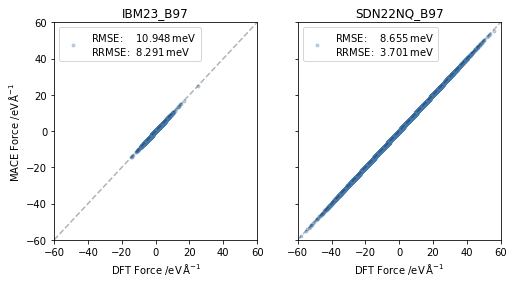

In [521]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}force_correlation/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,2, figsize=(4*2, 4*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(mace_forces, ref_forces)

    # Plot correlations
    axs[i].set_title(f'{data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\,$meV\nRRMSE:  {rrmse*1e3:.3f}$\,$meV', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('DFT Force /eV$\,$Å$^{-1}$')
    axs[i].set_xlim([-60,60])
    axs[i].set_ylim([-60,60])
    if i == 0: axs[i].set_ylabel('MACE Force /eV$\,$Å$^{-1}$')
    

### Densities and diffusivites
Running molecular dynamics with the two models reveals similar behaviour between them, implying that long range-effects on the local environment may not be that important for the dynamics. Both the density and the diffusivity are on par with each other, but we note that the cluster model seems to have a softer perspective of EMC than does the periodic model. One reason for this is, possibly, the fact that EMC is less frequently observed in all but the largest ans smallest clusters wheras EC is more uniformly spread across cluster compositions. Converesly, since the periodic model has been trained on the same type of local envrironments that is obeserved in the trajectory below the spread of EMC across this data set becomes more uniform as well.

On the surface level and in terms of the diffusivity, this seems rather well correlated with the density, seeing as the main difference between the models are the somewhat lower density in the pure EMC trajectory and higher diffusivity for the cluster based model. However, a log-log plot reveals that the cluster-model is barely converged with respect to mean-squared displacements. The periodic model, on the other hand, is more stable in that regard.

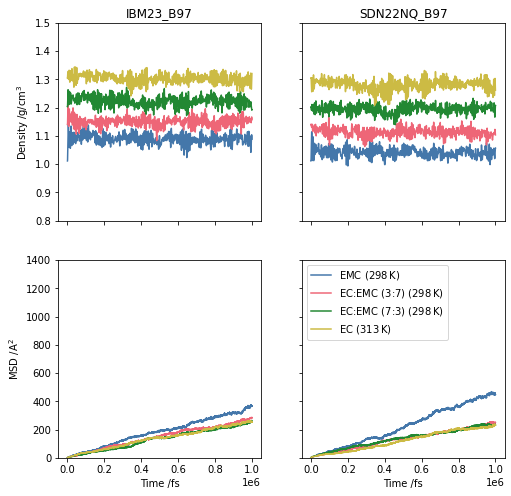

In [522]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(2,2, figsize=(4*2, 4*2), sharex=True, sharey='row')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    #print(tag)
    #print(thermo[k].keys())
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.8, 1.5])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name])

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name])

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
axs[-1,-1].legend(loc='upper left')

/tmp/ipykernel_408093/1163979954.py:11: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



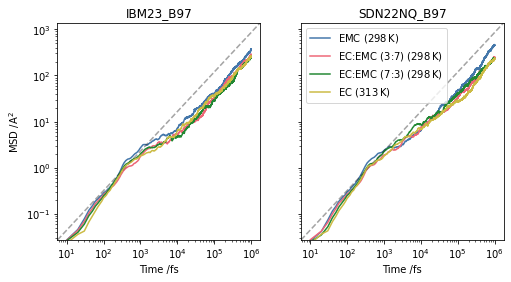

In [523]:
fig, axs = plt.subplots(1,2, figsize=(4*2, 4*1), sharey=True)
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name])

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
axs[-1].legend(loc='upper left')

### Data set size optimisation
(This is where we show how it all falls apart)

In [ ]:
tags = [
    'SDN22NQQ/wB97X/SEED1/DSET1',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQQ/wB97X/SEED1/DSET3',
    'SDN22NQQ/wB97X/SEED2/DSET1',
    'SDN22NQQ/wB97X/SEED3/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET2',
    'SDN22NQ/wB97X/SEED1/DSET3',
    #'SDN22NQ/wB97X/SEED2/DSET1', # this is missing, locally (Sams)
    #'SDN22NQ/wB97X/SEED3/DSET1', # this is missing, locally (Sams)
    'SDN22N/wB97X/SEED1/DSET1',
    'SDN22N/wB97X/SEED2/DSET1',
    'SDN22N/wB97X/SEED3/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

df = get_density(tags)
df

,Train data,Functional,Seed,Sample,Composition,Avg. density
0,SDN22NQQ,wB97X,1,1,"EMC (298$\,$K)",1.133707
1,SDN22NQQ,wB97X,1,1,"EC:EMC (3:7) (298$\,$K)",1.205010
2,SDN22NQQ,wB97X,1,1,"EC:EMC (7:3) (298$\,$K)",1.283700
3,SDN22NQQ,wB97X,1,1,"EC (313$\,$K)",1.379088
4,SDN22NQQ,wB97X,1,2,"EMC (298$\,$K)",1.131117
5,SDN22NQQ,wB97X,1,2,"EC:EMC (3:7) (298$\,$K)",1.201672
6,SDN22NQQ,wB97X,1,2,"EC:EMC (7:3) (298$\,$K)",1.292896
7,SDN22NQQ,wB97X,1,2,"EC (313$\,$K)",1.384449
8,SDN22NQQ,wB97X,1,3,"EMC (298$\,$K)",1.117259
9,SDN22NQQ,wB97X,1,3,"EC:EMC (3:7) (298$\,$K)",1.183245


### Data set sampling and seed variabilities
We reduced the SDN22NQ data set by another 25% to create the SDN22NQQ dataset. Furthermore, we created three different samples of each size and trained new models on these 6 data sets in conjunction with the full data set (SDN22N). This time the labels were kept the same as in the original data set (wB97X-D3BJ). The figure below shows the densities with the data set variability errors which are incredibly small. The reason for this is that the data samples were systematically generrated so as to keep as many of the larger clusters as possible. The effect is that the small, medium and large models mainly differ in the amount of small molecule clusters that they contain. The different versions of the small data set (SDN22NQQ) vary mostly in the single molecule structures, which are not really expected to result in entirely different behaviour. Especially given the number of these structures that are part of each data set.

Interestingly, we note that the small data set seems to be in agreement with the large data set and that the differences between the small and the medium can not be accounted for by the data set variability. Thus we see that the systematic selection of data points produces very similar models and we observe no systematic changes to teh density with respect to the data set size across the different compositions.

In [571]:
#### DATASET SAMPLING VARIABILITY
# Collect averages
sample_avg_df = get_average_density(df, 'Sample', 1)

# Pivot tables for plotting
## Focus averages
samp_avg_pivot_df = sample_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Avg. density',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)

## Focus variances for error bars
samp_std_pivot_df = sample_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Std.',
).sort_index(axis=0,ascending=False) 


### SEED VARIABILITY
# Collect averages
seed_avg_df = get_average_density(df, 'Seed', 1)

# Pivot tables for plotting
## Focus averages
seed_avg_pivot_df = seed_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Avg. density',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)

## Focus variances for error bars
seed_std_pivot_df = seed_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Std.',
).sort_index(axis=0,ascending=False) 

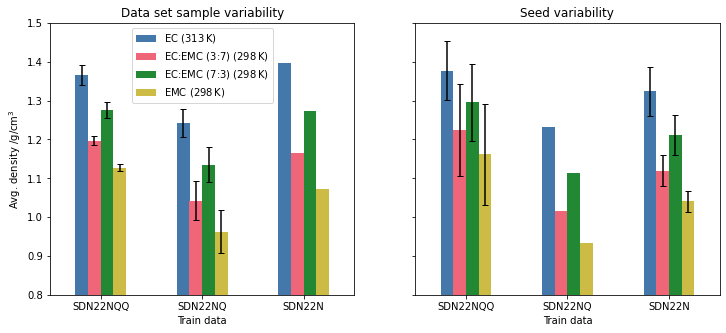

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(6*2,5),sharey=True)

# Plot data
axs[0].set_title('Data set sample variability')
samp_avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	ylabel=f'Avg. density /{dunit}',
	rot=0,
	yerr=samp_std_pivot_df,
	capsize=3,
	#figsize=(6,5),
	#legend=False,
	ax=axs[0],
)

# Plot data
axs[1].set_title('Seed variability')
seed_avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	#ylabel=f'Avg. density /{dunit}',
	rot=0,
	yerr=seed_std_pivot_df,
	capsize=3,
	#figsize=(6,5),
	legend=False,
	ax=axs[1],
)
axs[0].legend(loc='upper center')

# Discussion

## Possible sources of error
Here we start by doing some data analysis and to look for different correlations between properties etc.

### Cross correlation of forces

# Other questions and remarks
- Vscans for clusters, bulk and compared to DFT
    - Poor results: shows that this test is not rigorous
    - Good results: shows that this test is perhaps not a good test
- Force-correlations between models
    - Take the trajectories of each models (cluster v. bulk comparison), select a set of snapshot and recompute with B97 and do, for each model, force correlations compared with DFT reference
    - Correlate the two models, independent of DFT reference. Do a triangle-inequality check in force RMSE. Does it say anything?
- IMPORTANT: The schrodinger people systematically sampled structures that were strained or otherwise high in energy in order to have agreement across their QEq-committe. Since this is not of interest to us, it might just be that these structures are inappropriate to train a short-range model on. A different selection might have worked better!
- Check local environments. Take a model independent of any here, such as the MP0 model. Use it to generate fingerprints for the training sets (bulk and cluster) and to t-SNE test to see if they mix or not